In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'

In [3]:
!kaggle datasets download -d larjeck/uieb-dataset-raw

Dataset URL: https://www.kaggle.com/datasets/larjeck/uieb-dataset-raw
License(s): apache-2.0
 97% 617M/634M [00:03<00:00, 185MB/s]
100% 634M/634M [00:03<00:00, 181MB/s]


In [4]:
!unzip \*.zip && rm *.zip

Archive:  uieb-dataset-raw.zip
  inflating: raw-890/100_img_.png    
  inflating: raw-890/10139.png       
  inflating: raw-890/10151.png       
  inflating: raw-890/101_img_.png    
  inflating: raw-890/102_img_.png    
  inflating: raw-890/104_img_.png    
  inflating: raw-890/105_img_.png    
  inflating: raw-890/106_img_.png    
  inflating: raw-890/107_img_.png    
  inflating: raw-890/108_img_.png    
  inflating: raw-890/10909.png       
  inflating: raw-890/10945.png       
  inflating: raw-890/109_img_.png    
  inflating: raw-890/10_img_.png     
  inflating: raw-890/11052.png       
  inflating: raw-890/11064.png       
  inflating: raw-890/111_img_.png    
  inflating: raw-890/112_img_.png    
  inflating: raw-890/11374.png       
  inflating: raw-890/11398.png       
  inflating: raw-890/113_img_.png    
  inflating: raw-890/114_img_.png    
  inflating: raw-890/115_img_.png    
  inflating: raw-890/116_img_.png    
  inflating: raw-890/117_img_.png    
  inflating: raw-89

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import os
import matplotlib.pyplot as plt

# Enhanced SRCNN Model

class EnhancedSRCNN(nn.Module):
    def __init__(self):
        super(EnhancedSRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.relu(self.batch_norm3(self.conv3(x)))
        x = self.conv4(x)
        return x

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.png')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_names[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

image_dir = '/content/raw-890/'
train_dataset = CustomImageDataset(img_dir=image_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedSRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

import torch.nn.functional as F


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        low_res = transforms.Resize((64, 64))(data)  # Simulate low-resolution input
        low_res = low_res.to(device)
        high_res = data.to(device)
        outputs = model(low_res)
        outputs_upscaled = F.interpolate(outputs, size=(128, 128), mode='bicubic', align_corners=False)
        loss = criterion(outputs_upscaled, high_res)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


torch.save(model.state_dict(), '/content/srcnn.pth')



Epoch [1/10], Loss: 0.3194
Epoch [2/10], Loss: 0.0162
Epoch [3/10], Loss: 0.0060
Epoch [4/10], Loss: 0.0048
Epoch [5/10], Loss: 0.0040
Epoch [6/10], Loss: 0.0040
Epoch [7/10], Loss: 0.0034
Epoch [8/10], Loss: 0.0033
Epoch [9/10], Loss: 0.0033
Epoch [10/10], Loss: 0.0029


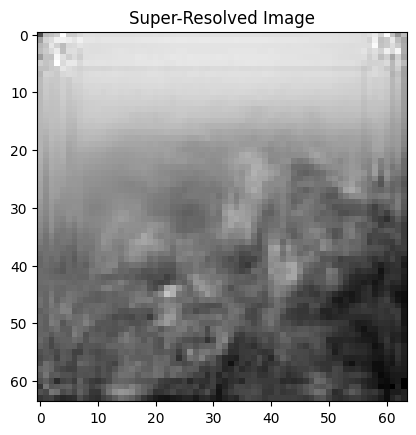

In [6]:
# Testing on a single image
model.eval()
test_image_path = '/content/raw-890/101_img_.png'
image = Image.open(test_image_path)
low_res = transform(image)
low_res = transforms.Resize((64, 64))(low_res).unsqueeze(0).to(device)

with torch.no_grad():
    sr_image = model(low_res).cpu().squeeze(0)
    save_image(sr_image, '/content/super_resolved_image.png')

plt.imshow(sr_image.permute(1, 2, 0).numpy(), cmap='gray')
plt.title('Super-Resolved Image')
plt.show()


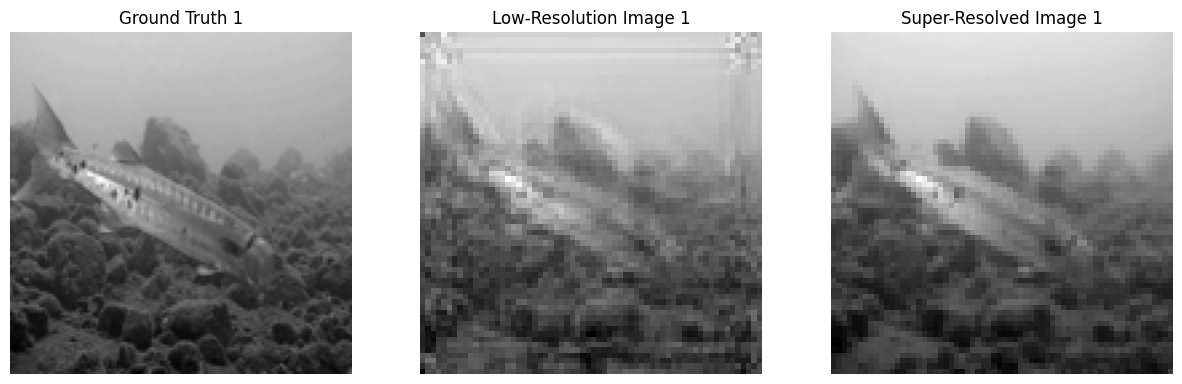

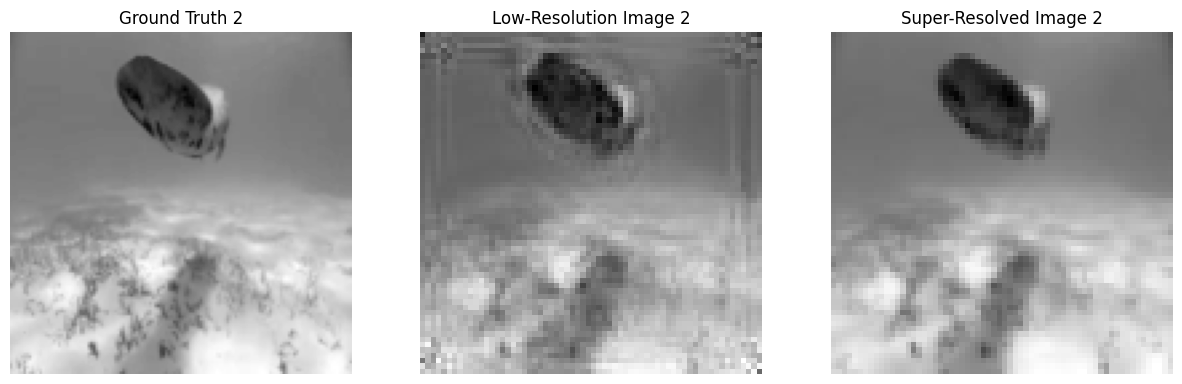

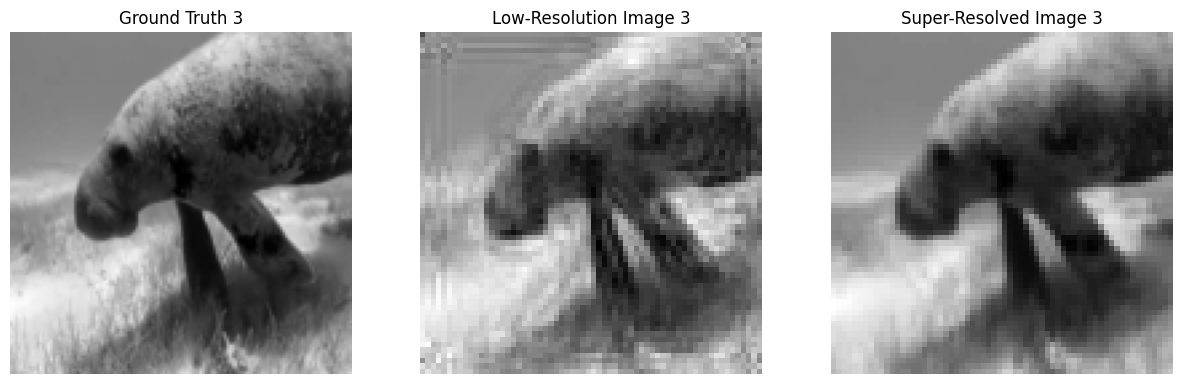

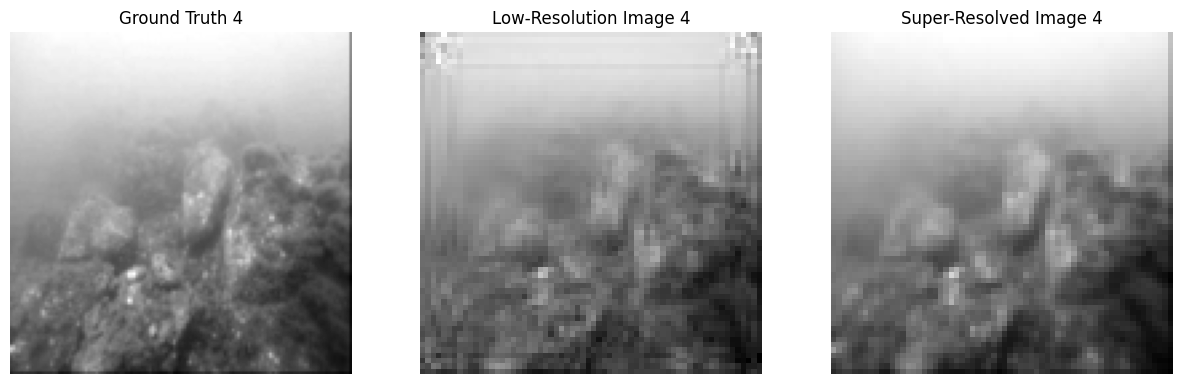

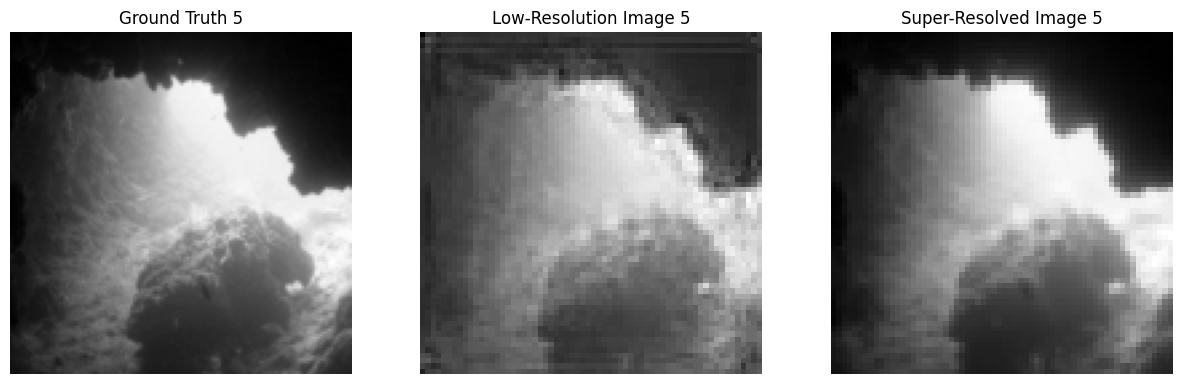

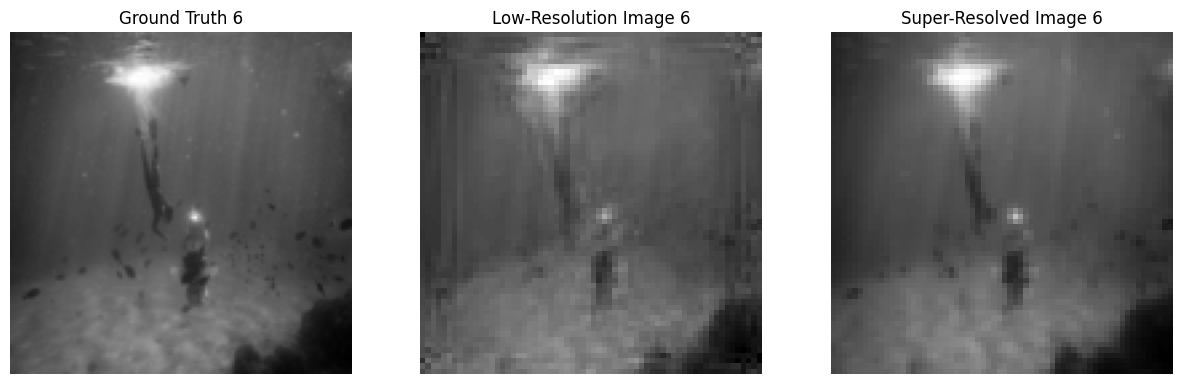

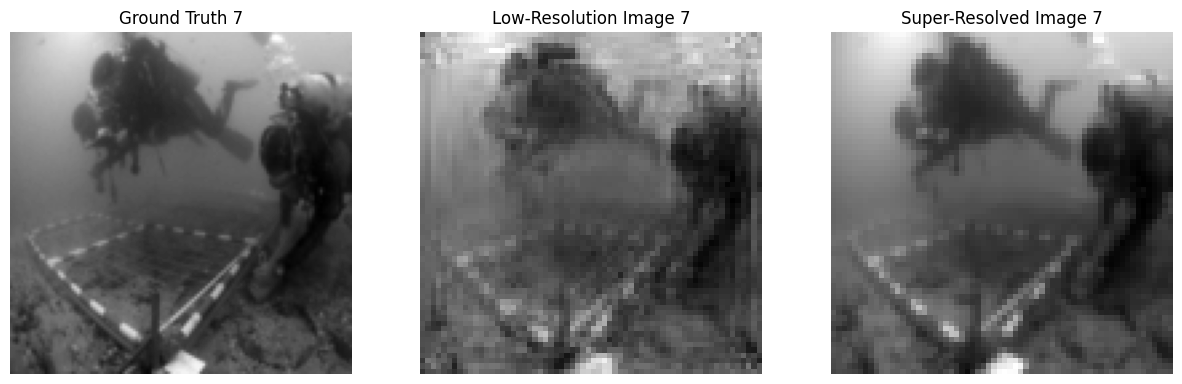

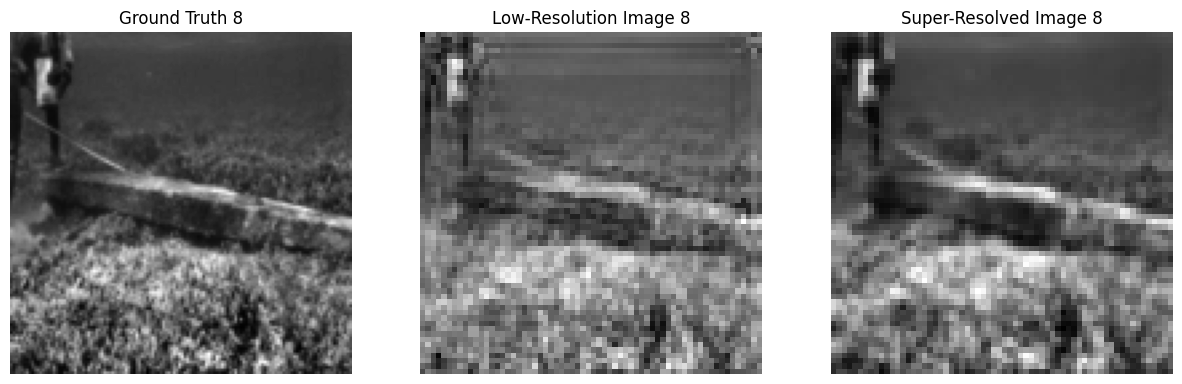

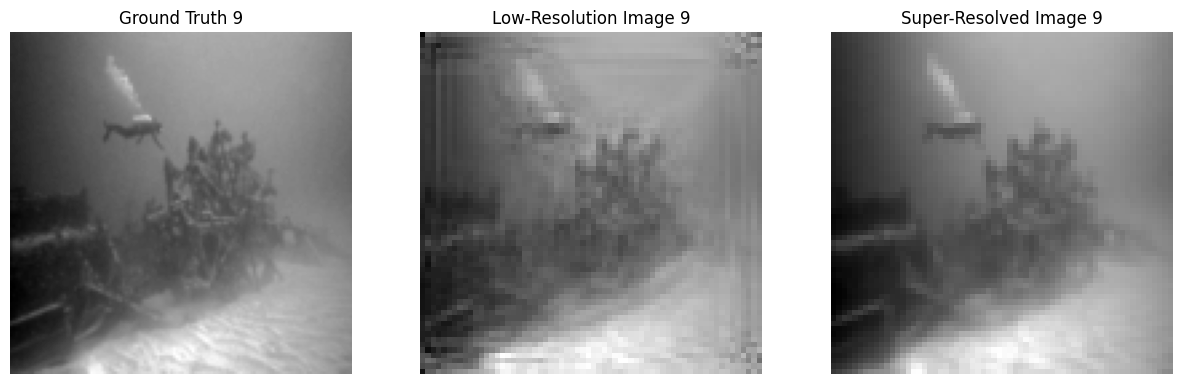

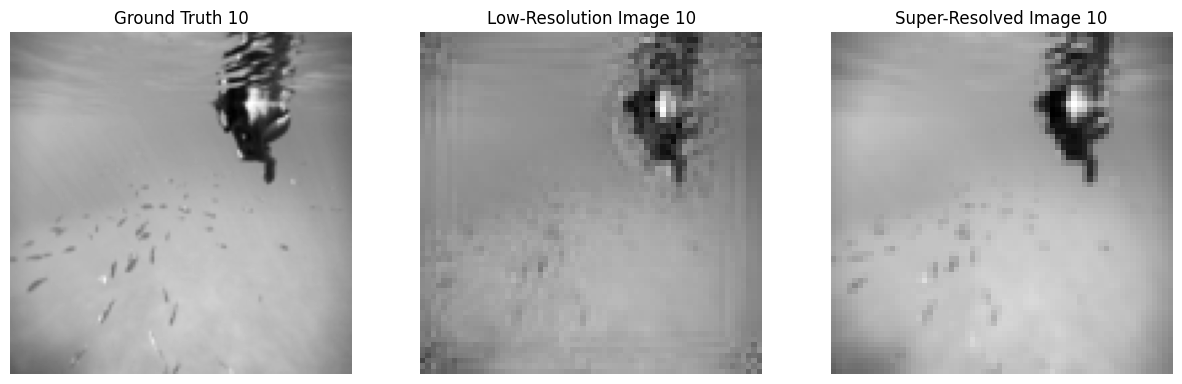

In [7]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

model.eval()

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


image_dir = '/content/raw-890/'
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])[:10]


for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    image = Image.open(img_path)
    high_res = transform(image)
    low_res = transforms.Resize((64, 64))(high_res).unsqueeze(0).to(device)

    with torch.no_grad():
        sr_image = model(low_res).cpu().squeeze(0)

    low_res_np = low_res.cpu().squeeze(0).permute(1, 2, 0).numpy()
    sr_image_np = sr_image.permute(1, 2, 0).numpy()
    high_res_np = high_res.permute(1, 2, 0).numpy()
    save_image(sr_image, f'/content/super_resolved_image_{i}.png')

    #plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(high_res_np, cmap='gray')
    axs[0].set_title(f'Ground Truth {i+1}')
    axs[0].axis('off')
    axs[1].imshow(sr_image_np, cmap='gray')
    axs[1].set_title(f'Low-Resolution Image {i+1}')
    axs[1].axis('off')
    axs[2].imshow(low_res_np, cmap='gray')
    axs[2].set_title(f'Super-Resolved Image {i+1}')
    axs[2].axis('off')

    plt.show()


In [13]:
import torch.nn.functional as F

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        low_res = transforms.Resize((64, 64))(data).to(device)
        high_res = data.to(device)
        outputs = model(low_res)
        outputs_upscaled = F.interpolate(outputs, size=(128, 128), mode='bicubic', align_corners=False)
        loss = criterion(outputs_upscaled, high_res)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.0267
Epoch [2/10], Loss: 0.0058
Epoch [3/10], Loss: 0.0044
Epoch [4/10], Loss: 0.0040
Epoch [5/10], Loss: 0.0034
Epoch [6/10], Loss: 0.0033
Epoch [7/10], Loss: 0.0028
Epoch [8/10], Loss: 0.0028
Epoch [9/10], Loss: 0.0027
Epoch [10/10], Loss: 0.0026


Epoch [1/10], Loss: 0.0027, PSNR: 26.08 dB
Epoch [2/10], Loss: 0.0022, PSNR: 26.77 dB
Epoch [3/10], Loss: 0.0023, PSNR: 26.71 dB
Epoch [4/10], Loss: 0.0021, PSNR: 27.19 dB
Epoch [5/10], Loss: 0.0021, PSNR: 26.96 dB
Epoch [6/10], Loss: 0.0019, PSNR: 27.40 dB
Epoch [7/10], Loss: 0.0020, PSNR: 27.28 dB
Epoch [8/10], Loss: 0.0021, PSNR: 27.31 dB
Epoch [9/10], Loss: 0.0019, PSNR: 27.46 dB
Epoch [10/10], Loss: 0.0019, PSNR: 27.73 dB


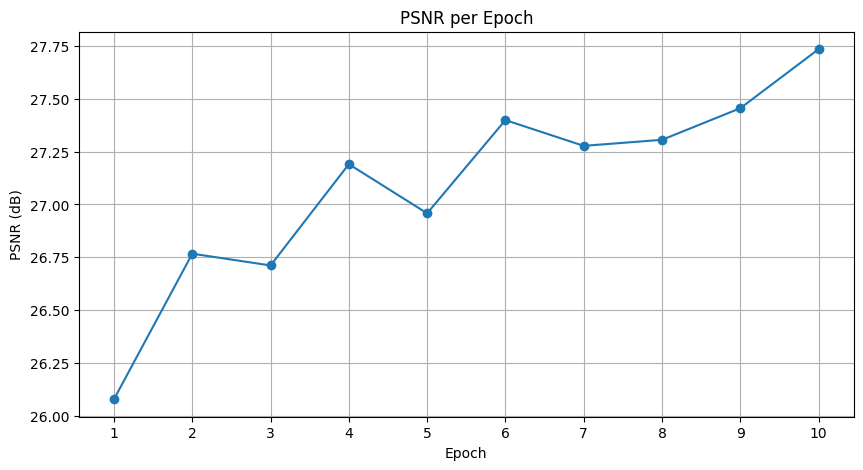

In [14]:
import math
import matplotlib.pyplot as plt

def calculate_psnr(output, target, max_pixel_value=1.0):
    mse = torch.mean((output - target) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(max_pixel_value / torch.sqrt(mse))
    return psnr
psnr_values = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_psnr = 0.0
    for data in train_loader:
        low_res = transforms.Resize((64, 64))(data).to(device)
        high_res = data.to(device)
        outputs = model(low_res)
        outputs_upscaled = F.interpolate(outputs, size=(128, 128), mode='bicubic', align_corners=False)
        loss = criterion(outputs_upscaled, high_res)
        psnr = calculate_psnr(outputs_upscaled, high_res)
        total_psnr += psnr
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    avg_psnr = total_psnr / len(train_loader)
    psnr_values.append(avg_psnr)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f} dB")

# Plotting the PSNR
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), psnr_values, marker='o')
plt.title('PSNR per Epoch')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.show()
